https://www.youtube.com/watch?v=6gk7giKER6s&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=7
To run locally
Good GPU - above 4GB Vram
Cuda Enabled
Cuda Tool Kit
Cuda NN


In [1]:
#https://www.youtube.com/watch?v=1gQR24B3ISE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=6
import os
import cv2
import numpy as np
from tqdm import tqdm

#in your pre-processing dataset you dont want to build data everytime you run your code
REBUILD_DATA = False

class DogsVSCats():
    #first, specify the size of the image i.e. 50 by 50
    #input images vary in sizes and shape (some are portrait, some are landscape) - we need them to uniform on input
    # normalised to the same size
    # resizing the images or resize and pad (adding white / black pixels on smaller images with open cv)
    #shift over and crop the image, rotate or flip them
    IMG_SIZE = 50
    CATS = "kagglecatsanddogs_3367a/PetImages/Cat"
    DOGS = "kagglecatsanddogs_3367a/PetImages/Dog"
    #Pre-labelled data
    LABELS ={CATS: 0, DOGS: 1}
    # massive list of images with their label
    training_data = []
    cat_count = 0
    dog_count = 0
        
    def make_training_data(self):
        for label in self.LABELS:
            print("directory: ",label)
            #looping all the images in the directory
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as e:
                    pass
                    #print(str(e))                    
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.cat_count)
        print("Dogs:", self.dog_count)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()
            
    

In [2]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

24946


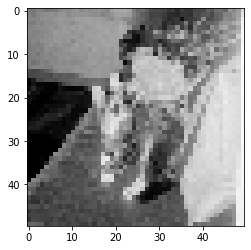

[array([[ 90,  88,  95, ..., 100, 114, 158],
       [ 95,  89,  98, ..., 106, 117, 166],
       [ 95,  98,  98, ..., 102, 121, 177],
       ...,
       [ 49,  50,  51, ..., 106, 174, 177],
       [ 39,  52,  50, ..., 104, 175, 177],
       [ 74,  76,  69, ..., 108, 180, 177]], dtype=uint8)
 array([1., 0.])]


In [3]:
import matplotlib.pyplot as plt
index = 16
plt.imshow(training_data[index][0], cmap= "gray")
plt.show()
print(training_data[index])

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        # self.fc1 = nn.Linear ( ??? , 512)
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
    def convs(self, x):
        #just like the forward method but only applying to the convolutional layers
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward (self,x):
        #required to know the flattened result after initializing during real forward pass
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #returning an activation layer rather than just x
        return F.softmax(x, dim = 1)
    
net = Net()

In [9]:
import torch.optim as optim

# All the parameters in the nn is controlled by the optimiser
## moved to bottom
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
#Scaling the imagery - between 0 - 1 from 0 - 255
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [6]:
train_X = X[: -val_size]
train_y = y[: -val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print("train_X is : ",len(train_X), "with train_y : ", len(train_y))
print("test_X is : ",len(test_X), "with test_y : ", len(test_y))

train_X is :  22452 with train_y :  22452
test_X is :  2494 with test_y :  2494


In [7]:
BATCH_SIZE = 100
EPOCHS = 1
#Slices of our data
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        print(i, i + BATCH_SIZE)

100%|██████████| 225/225 [00:00<00:00, 37468.47it/s]

0 100
100 200
200 300
300 400
400 500
500 600
600 700
700 800
800 900
900 1000
1000 1100
1100 1200
1200 1300
1300 1400
1400 1500
1500 1600
1600 1700
1700 1800
1800 1900
1900 2000
2000 2100
2100 2200
2200 2300
2300 2400
2400 2500
2500 2600
2600 2700
2700 2800
2800 2900
2900 3000
3000 3100
3100 3200
3200 3300
3300 3400
3400 3500
3500 3600
3600 3700
3700 3800
3800 3900
3900 4000
4000 4100
4100 4200
4200 4300
4300 4400
4400 4500
4500 4600
4600 4700
4700 4800
4800 4900
4900 5000
5000 5100
5100 5200
5200 5300
5300 5400
5400 5500
5500 5600
5600 5700
5700 5800
5800 5900
5900 6000
6000 6100
6100 6200
6200 6300
6300 6400
6400 6500
6500 6600
6600 6700
6700 6800
6800 6900
6900 7000
7000 7100
7100 7200
7200 7300
7300 7400
7400 7500
7500 7600
7600 7700
7700 7800
7800 7900
7900 8000
8000 8100
8100 8200
8200 8300
8300 8400
8400 8500
8500 8600
8600 8700
8700 8800
8800 8900
8900 9000
9000 9100
9100 9200
9200 9300
9300 9400
9400 9500
9500 9600
9600 9700
9700 9800
9800 9900
9900 10000
10000 10100
10100 10

In [10]:
BATCH_SIZE = 100
EPOCHS = 3
#Slices of our data
def train(net):
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()   
        print(f"Epoch: {epoch}. Loss: {loss}")

train(net)
# Do the fitment optimisation - zero the gradients

  0%|          | 1/225 [00:00<00:26,  8.33it/s]

Epoch: 0. Loss: 0.25281524658203125


  0%|          | 1/225 [00:00<00:27,  8.09it/s]

Epoch: 1. Loss: 0.2484213411808014


100%|██████████| 225/225 [00:27<00:00,  8.17it/s]

Epoch: 2. Loss: 0.1945650577545166


In [11]:
def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i])
            net_out = net(test_X[i].view(-1,1,50,50))[0]

            #print(real_class, net_out)
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round (correct/total,3))
test(net)

100%|██████████| 2494/2494 [00:03<00:00, 678.28it/s]

Accuracy:  0.719


In [12]:
# Start of GPU implementation

torch.cuda.is_available()

True

In [13]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [14]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [15]:
torch.cuda.device_count()

1

In [16]:
#takes our entire neural network and pops it up on to our GPU
#cannot default pytorch to GPU because alot of transactions between CPU and GPU 
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [17]:
#creates the nerual network on the device
net = Net().to(device)

In [22]:
#Not practical to put all the data on the GPU
#If you can have all the data on GPU -> do it
BATCH_SIZE = 100
EPOCHS = 5

def train_gpu(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    loss_function = nn.MSELoss()
    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            outputs = net(batch_X)
            loss = loss_function(outputs, batch_y)
            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch}. Loss: {loss}")
train_gpu(net)

        # Do the fitment optimisation - zero the gradients

  5%|▍         | 11/225 [00:00<00:02, 104.67it/s]

Epoch: 0. Loss: 0.17151504755020142


  5%|▌         | 12/225 [00:00<00:01, 111.01it/s]

Epoch: 1. Loss: 0.07996553927659988


  5%|▌         | 12/225 [00:00<00:01, 111.00it/s]

Epoch: 2. Loss: 0.1291702687740326


 10%|▉         | 22/225 [00:00<00:01, 109.23it/s]

Epoch: 3. Loss: 0.10065232217311859


100%|██████████| 225/225 [00:02<00:00, 105.88it/s]

Epoch: 4. Loss: 0.06606099754571915


In [23]:
def test_gpu(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i]).to(device)
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]

            #print(real_class, net_out)
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct += 1
            total += 1
    print("Accuracy: ", round (correct/total,3))
test_gpu(net)

100%|██████████| 2494/2494 [00:03<00:00, 694.74it/s]

Accuracy:  0.757


In [24]:
#Increase accuracy by - increasing EPOCH
# train again
train_gpu(net)

  5%|▌         | 12/225 [00:00<00:01, 111.01it/s]

Epoch: 0. Loss: 0.06726612895727158


  5%|▌         | 12/225 [00:00<00:01, 111.01it/s]

Epoch: 1. Loss: 0.06390628963708878


  5%|▌         | 12/225 [00:00<00:01, 111.01it/s]

Epoch: 2. Loss: 0.06745751202106476


  5%|▌         | 12/225 [00:00<00:01, 112.05it/s]

Epoch: 3. Loss: 0.040335386991500854


100%|██████████| 225/225 [00:02<00:00, 108.75it/s]

Epoch: 4. Loss: 0.02338463068008423


In [25]:
test_gpu(net)

100%|██████████| 2494/2494 [00:03<00:00, 699.87it/s]

Accuracy:  0.742
